In [73]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [74]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [75]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)
df['real_price'] = df.price
df['price'] = df.price.ewm(span=6, adjust=True).mean()

Text(0, 0.5, 'Price USD ($)')

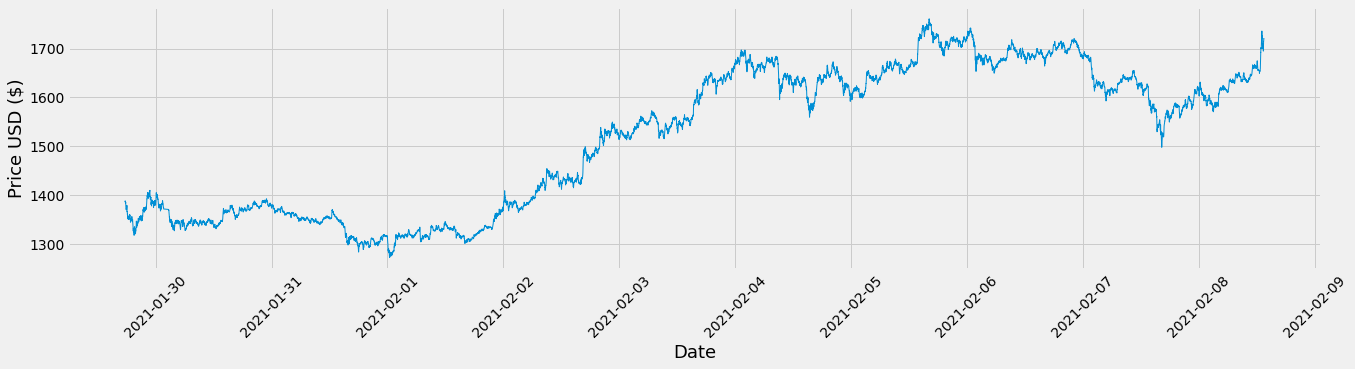

In [76]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
# plt.show()

In [77]:
def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*round(1+macd_multiplier*0.25), min_periods=macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 11)
macd_multiplier = 25

df['MACD_buy'], df['Signal Line'] = createMacdAndSignalLines(df.price, macd_params, 29)
df['MACD_sell'], _  = createMacdAndSignalLines(df.price, macd_params, 11)

In [78]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(50, len(df)):
        if (bought == False and getBuySignal(df, i)):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if (bought and getSellSignal(df, i, bought)):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], f"Bought at {bought:.2f}. Selling at {df['real_price'].iat[i]:.2f}. Profit: {df['real_price'].iat[i] - bought - 1:+.2f}")
            
            transactions.append(df['real_price'].iat[i] - bought)
            sumwin = sumwin + df['real_price'].iat[i] - bought - 1
            bought = False 
    return(sumwin, transactions)

def getBuySignal(df, i):
  return (df['MACD_buy'].iat[i] > df['Signal Line'].iat[i]) and (df['MACD_buy'].iat[i-1] <= df['Signal Line'].iat[i-1])
def getSellSignal(df, i, bought):
  return (df['MACD_sell'].iat[i] < df['Signal Line'].iat[i]) and (df['MACD_sell'].iat[i-1] >= df['Signal Line'].iat[i-1])

#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  bought = False
  for i in range(0,len(df)):
    #if MACD > signal line  then buy else sell
      if bought == False and getBuySignal(df, i):
        sigPriceBuy.append(signal['real_price'][i])
        sigPriceSell.append(np.nan)
        bought = signal['real_price'][i]
      elif bought != False and getSellSignal(df, i, bought): 
        sigPriceSell.append(signal['real_price'][i])
        sigPriceBuy.append(np.nan)
        bought = False
      else:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

#Create buy and sell columns
df['Buy_Signal_Price'], df['Sell_Signal_Price'] = buy_sell(df)


fig, axs = plt.subplots(2, figsize=(20, 7.5), sharex=True)
plt.xticks(rotation=45)
axs[0].plot( df['real_price'],  label='price', linewidth=1)
axs[0].scatter(df.index, df['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
axs[0].legend(loc='upper left')
axs[0].set_ylabel('ETH in USD')
axs[1].plot(df.index, df['MACD_buy'], label='Buy line', color = 'green', linewidth=1)
axs[1].plot(df.index, df['MACD_sell'], label='Sell line', color = 'red', linewidth=1)
axs[1].plot(df.index, df['Signal Line'], label='Signal Line', color='blue', linewidth=1.5)
axs[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

r = mac_daddy_tester(df)
print("Profit", r[0])
print("Transactions: ", len(r[1]))
plt.boxplot(r[1])
plt.show()

KeyboardInterrupt: 

In [71]:
results = []
macd_params = (12, 26, 9)
max_p = -99999
for period_length1 in np.arange(1, 120, 1):
    for period_length2 in np.arange(1, 70, 1):
        df["MACD_buy"], signal = createMacdAndSignalLines(df.price, macd_params, period_length1)
        df["MACD_sell"], _ = createMacdAndSignalLines(df.price, macd_params, period_length2)
        r = mac_daddy_tester(df, quiet=True)
        results.append((period_length1, period_length2, r[0], len(r[1])))
        if r[0] > max_p:
            max_p = r[0]
            print("Buy period:", period_length1, "Sell period:", period_length2, "Profit", r[0], "transactions: ", len(r[1]))
    # print(sorted(results, key = lambda x: -x[2]))

Buy period: 1 Sell period: 1 Profit -51.11400500000036 transactions:  15
Buy period: 1 Sell period: 6 Profit -38.28250000000003 transactions:  8
Buy period: 1 Sell period: 8 Profit -37.09499999999957 transactions:  8
Buy period: 1 Sell period: 9 Profit -7.8794900000000325 transactions:  9
Buy period: 1 Sell period: 13 Profit 0.7001749999999447 transactions:  10
Buy period: 1 Sell period: 45 Profit 3.0875000000003183 transactions:  5
Buy period: 1 Sell period: 49 Profit 3.9926135000000613 transactions:  4
Buy period: 1 Sell period: 50 Profit 4.187818000000107 transactions:  4
Buy period: 1 Sell period: 52 Profit 4.779999999999973 transactions:  4
Buy period: 1 Sell period: 54 Profit 5.109427500000038 transactions:  4
Buy period: 1 Sell period: 60 Profit 22.79184050000049 transactions:  5
Buy period: 1 Sell period: 61 Profit 23.955000000000155 transactions:  5
Buy period: 1 Sell period: 62 Profit 26.180000000000064 transactions:  5
Buy period: 1 Sell period: 63 Profit 26.63000000000011 t

KeyboardInterrupt: 

In [84]:
# print(sorted(results, key = lambda x: -x[2]))
maxi = 0
for r in results:
    if r[2] >= maxi:
        maxi = r[2]
        print(r)

(1, 1, 93.1135815000016, 76)
(1, 3, 114.6290590000001, 47)
(1, 10, 119.83019750000085, 33)
(1, 11, 136.08654300000035, 33)
(16, 1, 141.600720500001, 31)
(17, 9, 146.55993599999942, 34)
(17, 10, 153.4640530000006, 34)
(17, 11, 165.88557700000024, 34)
(20, 31, 177.03312749999964, 22)
(22, 31, 186.87812749999966, 22)
(26, 31, 186.90062749999925, 28)
(26, 35, 187.22248899999954, 16)
(26, 38, 193.29322399999955, 11)
(26, 40, 194.6340474999995, 10)
(26, 41, 195.50172799999973, 10)
(27, 61, 201.05999999999995, 8)
(28, 11, 206.65154299999995, 35)
(29, 4, 209.2744085000013, 41)
(29, 7, 209.71887250000054, 36)
(29, 8, 219.66940000000022, 36)
(29, 10, 227.54751900000042, 33)
(29, 11, 243.0690430000002, 33)


# Best results:
Using different buy sell macd lines (12, 26, 9): 

Multipliers:

* Buy: x21 Sell: x45 = $295
* Buy: x12 Sell: x45 = $287
* Buy: x16 Sell: x43 = $284
* Buy: x9 Sell: x43 = $282


Try using scaled period line with round(1+multiplier*.25) on the signal line
* Buy: x29 Sell: x8 = $219
* Buy: x29 Sell: x10 = $227
* Buy: x29 Sell: x11 = $243